In [1]:
import os
import pandas as pd

from tqdm.notebook import tqdm

from pyphylon.downloads import download_genomes_bvbrc
from pyphylon.util import load_config

In [2]:
CONFIG = load_config("config.yml")
WORKDIR = CONFIG["WORKDIR"]
SPECIES = CONFIG["PG_NAME"]

# Select Strains for Affinity Inference

Select strains for which to infer affinities. Place these strains as .fna files into the directory `/examples/data/inferring_affinities/input_strains`.

Below, 5 strains are downloaded as an example.

In [3]:
# Make output directories
INFERRING_AFFINITIES = os.path.join(WORKDIR, 'inferring_affinities')
OUTPUT_DIR = os.path.join(INFERRING_AFFINITIES, "input_strains")
if not os.path.exists(INFERRING_AFFINITIES):
    os.makedirs(INFERRING_AFFINITIES)

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
genomes_to_download = [
'1115817.3',
'1115814.3',
'1115827.3',
'1115819.3',
'1115812.3',
]

In [ ]:
bad_genomes = download_genomes_bvbrc(
    genomes=genomes_to_download,
    output_dir=OUTPUT_DIR,
    filetypes=['fna']
)

# Run Script to Combine Sequences with the CD-HIT Pangenome

Following the same protocol as the README describes, run the Snakefile in `workflow/infer_affinities` to combine assess new strains against the pangenome by first running MASH and CD-HIT-2D.

Alternatively download the pre-processed files [here](https://www.dropbox.com/scl/fi/28whs7wq5npqtoucgbott/inferring_affinities.rar?rlkey=seilyyci8hhn2g04djbbhjudb&st=sfbtnvwr&dl=0) and unzip the "inferring_affinities" folder into the examples/data folder

# Analyze the Results

## Load Data

In [5]:
# Load in (full) P matrix
df_genes = pd.read_pickle(os.path.join(WORKDIR, f'processed/cd-hit-results/{SPECIES}_strain_by_gene.pickle.gz'))

# Load in metadata
ENRICHED_METADATA = os.path.join(WORKDIR, 'interim/enriched_metadata_2d.csv')
# Load in (full) metadata
metadata = pd.read_csv(ENRICHED_METADATA, index_col=0, dtype='object')

# Filter metadata for Complete sequences only
metadata = metadata[metadata.genome_status == 'Complete'] # filter for only Complete sequences

# Filter P matrix for Complete sequences only
df_genes_complete = df_genes[metadata.genome_id].copy()
df_genes_complete.fillna(0, inplace=True) # replace N/A with 0
df_genes_complete = df_genes_complete.sparse.to_dense().astype('int8') # densify & typecast to int8 for space and compute reasons
inCompleteseqs = df_genes_complete.sum(axis=1) > 0 # filter for genes found in complete sequences
df_genes_complete = df_genes_complete[inCompleteseqs]

metadata = metadata.set_index('genome_id')

L_BIN = os.path.join(WORKDIR, 'processed/nmf-outputs/L_binarized.csv')
L_binarized = pd.read_csv(L_BIN, index_col=0)

L_NORM = os.path.join(WORKDIR, 'processed/nmf-outputs/L_norm.csv')
L_norm = pd.read_csv(L_NORM, index_col=0)

A_NORM = os.path.join(WORKDIR, 'processed/nmf-outputs/A_norm.csv')
A_norm = pd.read_csv(A_NORM, index_col=0)

## Classify new strains against MASH clusters

In [6]:
MASH_DISTANCES = os.path.join(WORKDIR, 'inferring_affinities', 'combined_mash_distances.csv')

mash_distances = pd.read_csv(MASH_DISTANCES, dtype = 'object').set_index('genome_id').astype(float)

In [7]:
strain_mash_clusters = pd.DataFrame(columns = ['best_cluster', 'nearest_mash_distance_mean'])

for new_strain in mash_distances.columns:
    top_distances = mash_distances[new_strain].sort_values().index[:5] # get 5 closest strains
    mash_cluster = int(float(metadata.loc[top_distances].mash_cluster.value_counts().idxmax()))
    strain_mash_clusters.loc[new_strain] = [mash_cluster,
                                            mash_distances[new_strain].sort_values().head(5).mean()]

In [8]:
strain_mash_clusters

,best_cluster,nearest_mash_distance_mean
1115812.3_distances,2.0,0.011445
1115814.3_distances,17.0,0.009936
1115817.3_distances,3.0,0.007297
1115819.3_distances,3.0,0.004689
1115827.3_distances,8.0,0.011389


## Assign Phylon Affinities

In [9]:
from pyphylon.infer_affinities import *
from pyphylon.models import recommended_threshold
import seaborn as sns

In [46]:
P_NEW = os.path.join(WORKDIR, 'inferring_affinities', 'combined_P_matrix.csv')
P_new = pd.read_csv(P_NEW, index_col=0)
# P_new = P_new.reindex(df_genes.index, fill_value=0)
P_new = pd.concat([df_genes, P_new], axis=1).fillna(0)

P_new_acc = P_new.loc[L_norm.index]

In [47]:
A_new = infer_affinities(L_norm.to_numpy(),  P_new_acc.to_numpy(), n_jobs=4)
A_new = pd.DataFrame(A_new, index = L_norm.columns, columns = P_new_acc.columns)

  0%|          | 0/51 [00:00<?, ?it/s]

<Axes: >

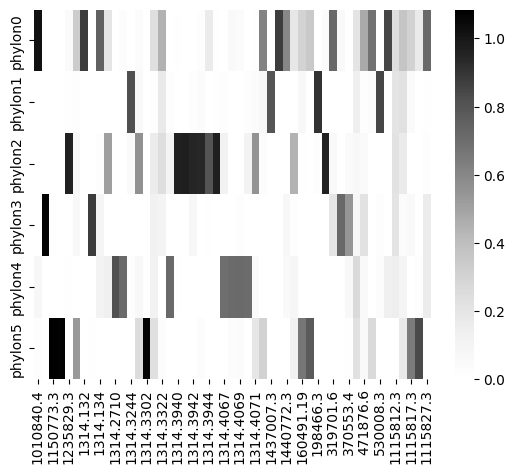

In [48]:
# Basic binarization with thresholds from original matrix:
A_binarized_new = pd.DataFrame(np.zeros_like(A_new.values), index=A_norm.index, columns=A_new.columns)


for idx in A_norm.index: # 90% of threshold for original A matrix used to account for CD-HIT clustering incongruities on strains
    cond = A_new.loc[idx] >= recommended_threshold(A_norm, idx.split('n')[1]) * .9
    A_binarized_new.loc[idx,cond] = 1

sns.heatmap(A_new, cmap='Greys')